---
title: "2D Data Visualization"
jupyter: advnetsci
execute:
    enabled: true
---

You've probably heard that "correlation doesn't equal causation." But here's an even more fundamental problem: **a correlation coefficient doesn't tell you what your data actually looks like.**

In 1973, statistician Francis Anscombe created four datasets that became legendary in data visualization. Each dataset has 11 (x, y) pairs. Each has the same mean for x and y, the same variance, andmost remarkably---the same correlation coefficient (r = 0.816) and the same linear regression line.

But when you plot them, they tell completely different stories.

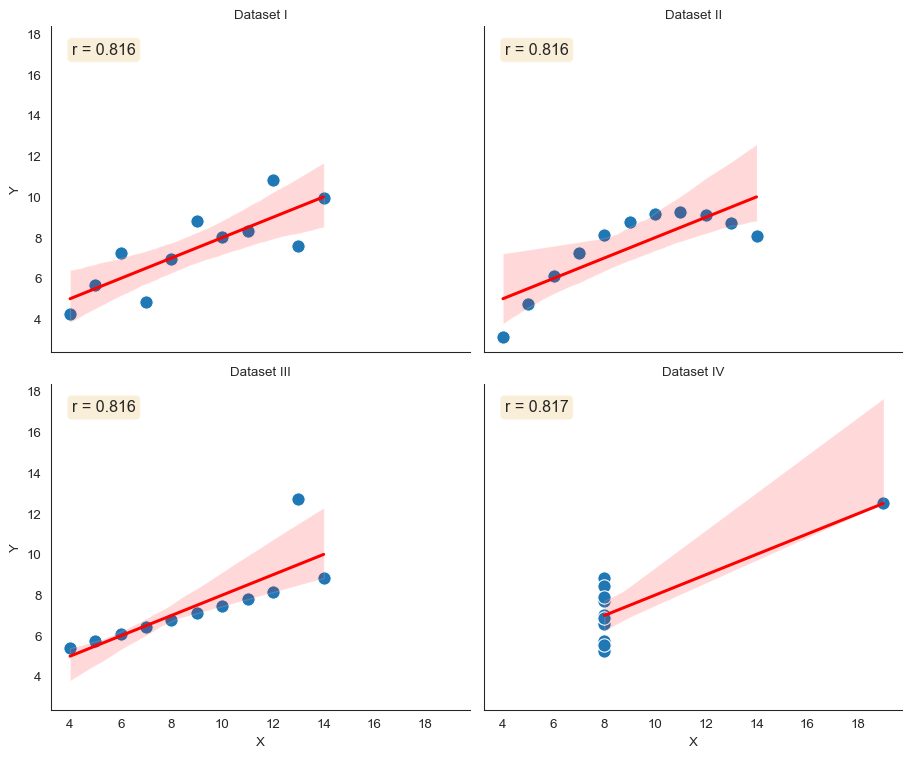

In [1]:
#| fig-cap: 'Anscombe''s Quartet: Four datasets with identical summary statistics but completely different relationships'
#| code-fold: true
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load Anscombe's quartet
anscombe = sns.load_dataset("anscombe")

# Create the plot
sns.set_style("white")
g = sns.FacetGrid(anscombe, col="dataset", col_wrap=2, height=4, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="x", y="y", s=100)
g.map_dataframe(sns.regplot, x="x", y="y", scatter=False, color="red")
g.set_axis_labels("X", "Y")
g.set_titles("Dataset {col_name}")

# Add correlation to each subplot
for ax, dataset in zip(g.axes.flat, ["I", "II", "III", "IV"]):
    data_subset = anscombe[anscombe["dataset"] == dataset]
    r = np.corrcoef(data_subset["x"], data_subset["y"])[0, 1]
    ax.text(0.05, 0.95, f'r = {r:.3f}', transform=ax.transAxes,
            verticalalignment='top', fontsize=12, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

sns.despine()
plt.tight_layout()

Dataset I shows a nice linear relationship. Dataset II is clearly non-linear---a parabola that a linear model completely misses. Dataset III has a perfect linear relationship except for one outlier that changes everything. Dataset IV shows no relationship except for a single influential point that creates the illusion of correlation.

The same correlation coefficient. The same regression line. Completely different data.

This is why we visualize relationships:

**Always plot your bivariate data. Summary statistics conceal structure.**

# Showing All Points: Scatter Plots

The most direct way to show a relationship between two variables is to plot every point. A **scatter plot** does exactly this: each observation becomes a point in 2D space.

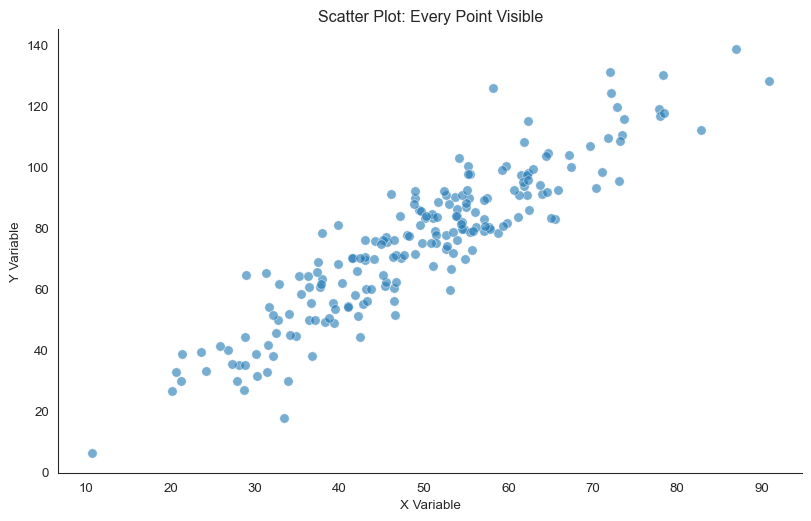

In [2]:
#| fig-cap: Basic scatter plot showing relationship between two variables
#| code-fold: true
# Generate sample data with clear relationship
np.random.seed(42)
n_points = 200
x = np.random.normal(50, 15, n_points)
y = 1.5 * x + np.random.normal(0, 10, n_points)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
ax.set_xlabel('X Variable')
ax.set_ylabel('Y Variable')
ax.set_title('Scatter Plot: Every Point Visible')
sns.despine()

For small to moderate datasets (up to ~1,000 points), scatter plots are perfect. You can see:
- The strength and direction of the relationship
- The spread around the trend
- Individual outliers
- Non-linear patterns
- Clusters or subgroups

When points overlap heavily, use **transparency (alpha)**. This creates natural density shading---areas with many overlapping points appear darker.

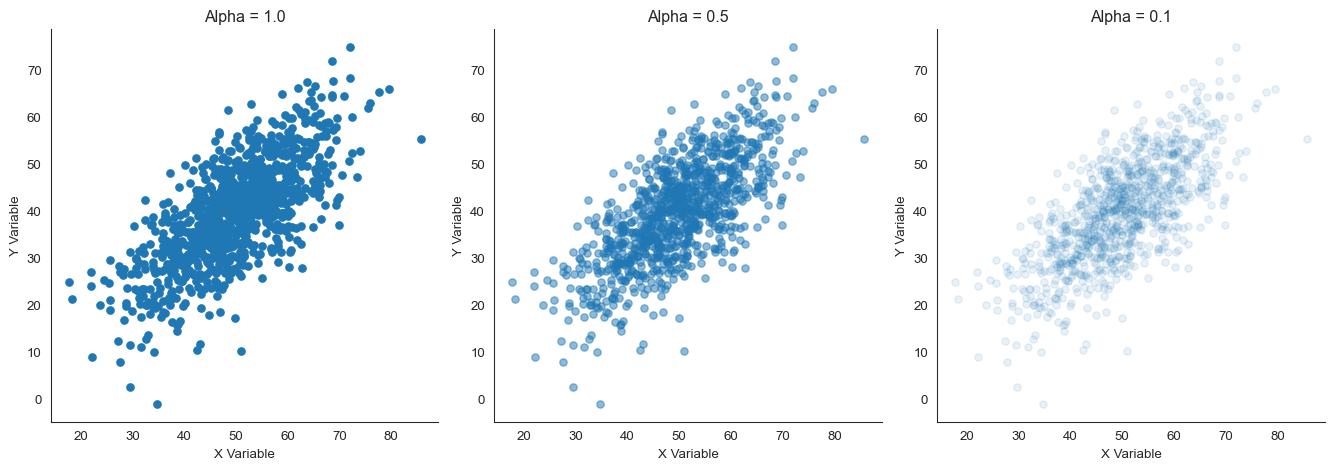

In [3]:
#| fig-cap: Scatter plots with different alpha values showing how transparency reveals density
#| code-fold: true
# Generate data with heavy overlap
np.random.seed(123)
n_points = 1000
x_overlap = np.random.normal(50, 10, n_points)
y_overlap = 0.8 * x_overlap + np.random.normal(0, 8, n_points)

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
alphas = [1.0, 0.5, 0.1]

for ax, alpha in zip(axes, alphas):
    ax.scatter(x_overlap, y_overlap, alpha=alpha, s=30)
    ax.set_xlabel('X Variable')
    ax.set_ylabel('Y Variable')
    ax.set_title(f'Alpha = {alpha}')
    sns.despine(ax=ax)

plt.tight_layout()

With alpha = 1.0 (opaque), the center is a solid blob---you can't tell if there are 10 points or 100. With alpha = 0.1, the density gradient becomes visible. Dark regions have many points; light regions have few.

::: {.column-margin}

![](https://www.science.org/cms/10.1126/science.aan8627/asset/d92c8e9c-6bad-48ad-a006-f9e76c62b72a/assets/graphic/358_1042_f3.jpeg)

A figure from [Metaanalysis of faculty's teaching effectiveness](https://www.science.org/doi/10.1126/science.aan8627) showing the relationship between student evaluation of teaching and actual learning. Each bubble represents a course section, with size proportional to the number of students. Notice how transparency reveals the density of observations.

:::

For extremely dense data where even transparency doesn't help, **jittering** can separate overlapping points by adding small random noise to their positions.

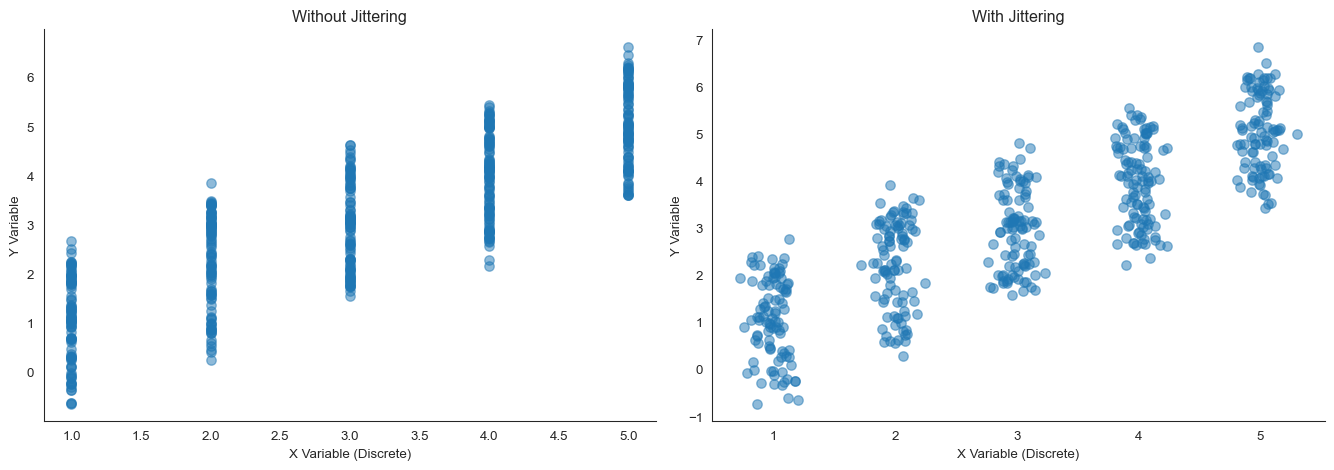

In [4]:
#| fig-cap: Jittering helps separate discrete or overlapping points
#| code-fold: true
# Generate data with discrete values (common in survey data)
np.random.seed(456)
n_points = 500
x_discrete = np.random.choice([1, 2, 3, 4, 5], n_points)
y_discrete = x_discrete + np.random.choice([-1, 0, 1], n_points) + np.random.normal(0, 0.3, n_points)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Without jitter
axes[0].scatter(x_discrete, y_discrete, alpha=0.5, s=50)
axes[0].set_xlabel('X Variable (Discrete)')
axes[0].set_ylabel('Y Variable')
axes[0].set_title('Without Jittering')
sns.despine(ax=axes[0])

# With jitter
jitter_x = x_discrete + np.random.normal(0, 0.1, n_points)
jitter_y = y_discrete + np.random.normal(0, 0.1, n_points)
axes[1].scatter(jitter_x, jitter_y, alpha=0.5, s=50)
axes[1].set_xlabel('X Variable (Discrete)')
axes[1].set_ylabel('Y Variable')
axes[1].set_title('With Jittering')
sns.despine(ax=axes[1])

plt.tight_layout()

Without jittering, many points stack on top of each other---you might think there are only 25 data points (5 � 5) when there are actually 500. Jittering reveals the true sample size and density at each location.

# When Points Overlap: Binning Methods

When you have tens of thousands of points, even transparency and jittering don't fully reveal the density structure. Individual points become less meaningful than the overall pattern. This is when we need to **bin** the datadivide the 2D space into regions and count observations in each.

## 2D Histograms (Heatmaps)

A **2D histogram** extends the 1D histogram concept to two dimensions. The plane is divided into rectangular bins, and each bin's color represents the number of points it contains.

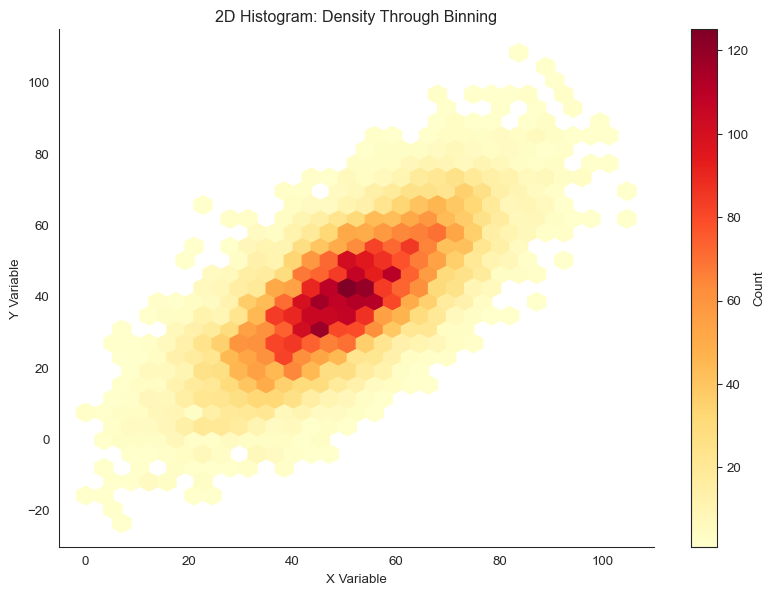

In [5]:
#| fig-cap: 2D histogram showing density through rectangular bins
#| code-fold: true
# Generate large dataset
np.random.seed(789)
n_large = 10000
x_large = np.random.normal(50, 15, n_large)
y_large = 0.8 * x_large + np.random.normal(0, 12, n_large)

fig, ax = plt.subplots(figsize=(10, 7))
hb = ax.hexbin(x_large, y_large, gridsize=30, cmap='YlOrRd', mincnt=1)
ax.set_xlabel('X Variable')
ax.set_ylabel('Y Variable')
ax.set_title('2D Histogram: Density Through Binning')
cb = plt.colorbar(hb, ax=ax)
cb.set_label('Count')
sns.despine()

The key parameter is **bin size** (or `gridsize`). Too few bins and you lose detail; too many bins and the plot becomes noisy. Like 1D histograms, this requires experimentation.

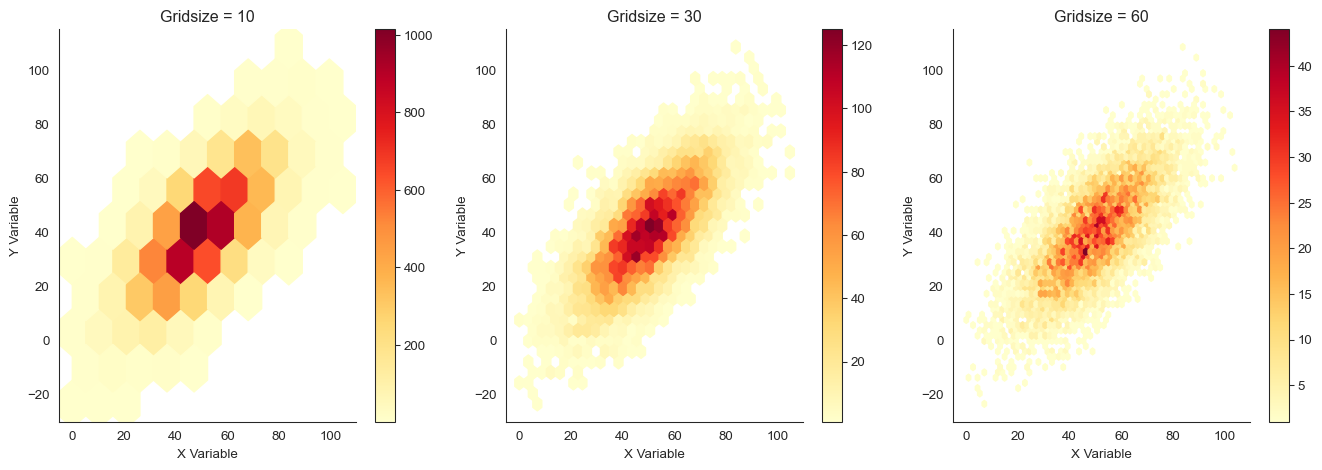

In [6]:
#| fig-cap: Effect of bin size on 2D histograms
#| code-fold: true
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
gridsizes = [10, 30, 60]

for ax, gridsize in zip(axes, gridsizes):
    hb = ax.hexbin(x_large, y_large, gridsize=gridsize, cmap='YlOrRd', mincnt=1)
    ax.set_xlabel('X Variable')
    ax.set_ylabel('Y Variable')
    ax.set_title(f'Gridsize = {gridsize}')
    plt.colorbar(hb, ax=ax)
    sns.despine(ax=ax)

plt.tight_layout()

With gridsize = 10, we see only coarse structure. With gridsize = 60, the plot is noisysome bins have few points by chance. Gridsize = 30 provides a good balance.

## Hexbin Plots

**Hexagonal binning** uses hexagons instead of rectangles. Hexagons are better for 2D binning because they're closer to circlesevery edge is equidistant from the center, reducing bias in how we perceive density.

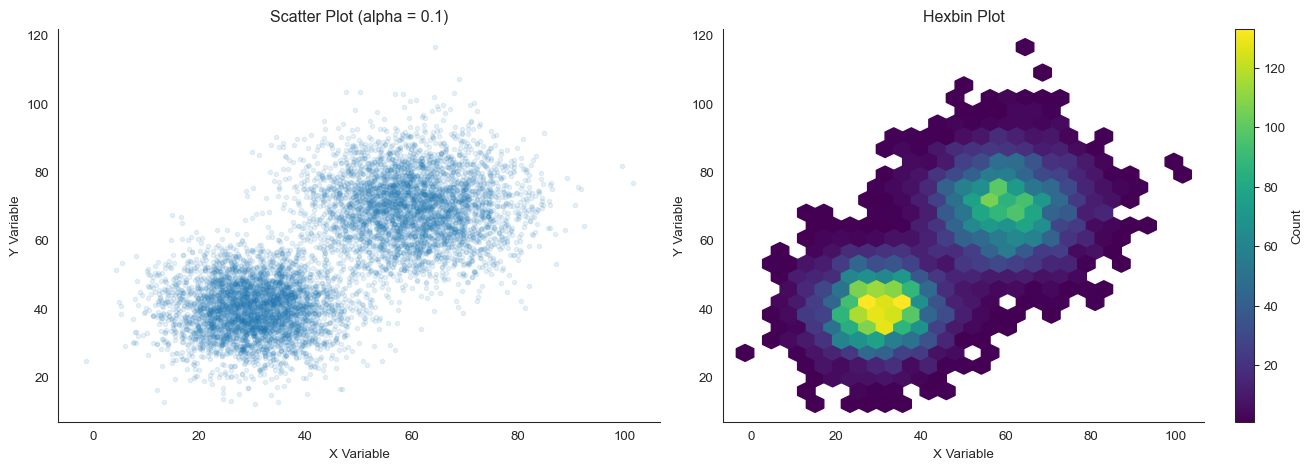

In [7]:
#| fig-cap: Hexbin plot provides more perceptually uniform density representation
#| code-fold: true
# Generate data with interesting structure
np.random.seed(101)
n = 8000

# Create two clusters
cluster1_x = np.random.normal(30, 8, n // 2)
cluster1_y = np.random.normal(40, 8, n // 2)
cluster2_x = np.random.normal(60, 10, n // 2)
cluster2_y = np.random.normal(70, 10, n // 2)

x_clusters = np.concatenate([cluster1_x, cluster2_x])
y_clusters = np.concatenate([cluster1_y, cluster2_y])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot (for reference)
axes[0].scatter(x_clusters, y_clusters, alpha=0.1, s=10)
axes[0].set_xlabel('X Variable')
axes[0].set_ylabel('Y Variable')
axes[0].set_title('Scatter Plot (alpha = 0.1)')
sns.despine(ax=axes[0])

# Hexbin plot
hb = axes[1].hexbin(x_clusters, y_clusters, gridsize=25, cmap='viridis', mincnt=1)
axes[1].set_xlabel('X Variable')
axes[1].set_ylabel('Y Variable')
axes[1].set_title('Hexbin Plot')
plt.colorbar(hb, ax=axes[1], label='Count')
sns.despine(ax=axes[1])

plt.tight_layout()

The hexbin plot clearly reveals the two clusters and their relative densitiessomething that's harder to see in the scatter plot even with low alpha.

Hexbin plots are particularly powerful for **very large datasets** (100,000+ points) where scatter plots become computationally expensive and visually overwhelming.

::: {.callout-note}
## Choosing colors for density plots

When showing density or counts, use **sequential colormaps** that vary in lightness: light = low density, dark = high density. Good choices include:
- `'YlOrRd'` (yellow-orange-red)
- `'viridis'` (purple-blue-green-yellow, perceptually uniform)
- `'Blues'` or `'Reds'` (single hue)

Avoid rainbow colormaps like `'jet'`they create artificial boundaries where none exist and are not perceptually uniform.
:::

# Smooth Density Estimation: 2D KDE

Just as 1D kernel density estimation (KDE) provides a smooth alternative to histograms, **2D KDE** smooths 2D histograms by placing a kernel at each data point and summing them.

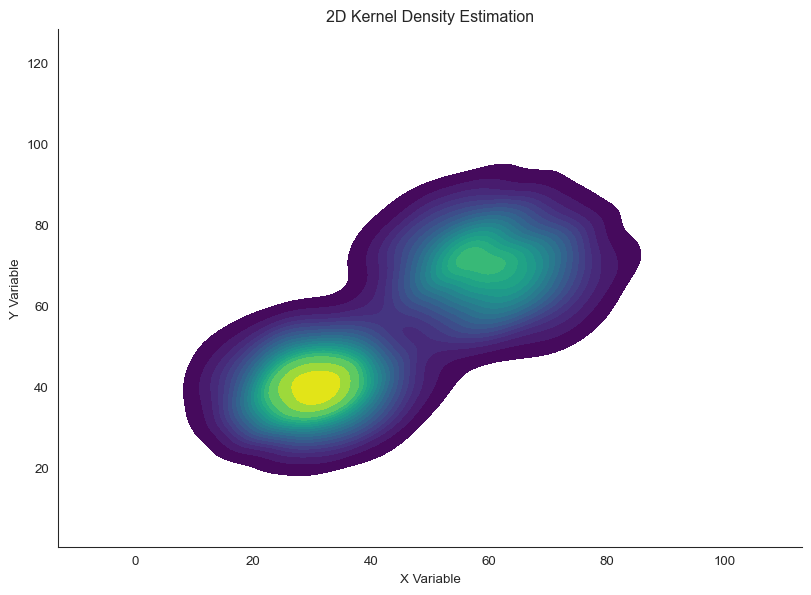

In [8]:
#| fig-cap: 2D kernel density estimation provides smooth density surface
#| code-fold: true
# Use the clustered data
fig, ax = plt.subplots(figsize=(10, 7))
sns.kdeplot(x=x_clusters, y=y_clusters, cmap='viridis', fill=True, thresh=0.05, levels=20, ax=ax)
ax.set_xlabel('X Variable')
ax.set_ylabel('Y Variable')
ax.set_title('2D Kernel Density Estimation')
sns.despine()

KDE reveals smooth density gradients without arbitrary binning decisions. The key parameter is **bandwidth**how wide each kernel is. Small bandwidth gives high detail but can be noisy; large bandwidth is smooth but may blur important features.

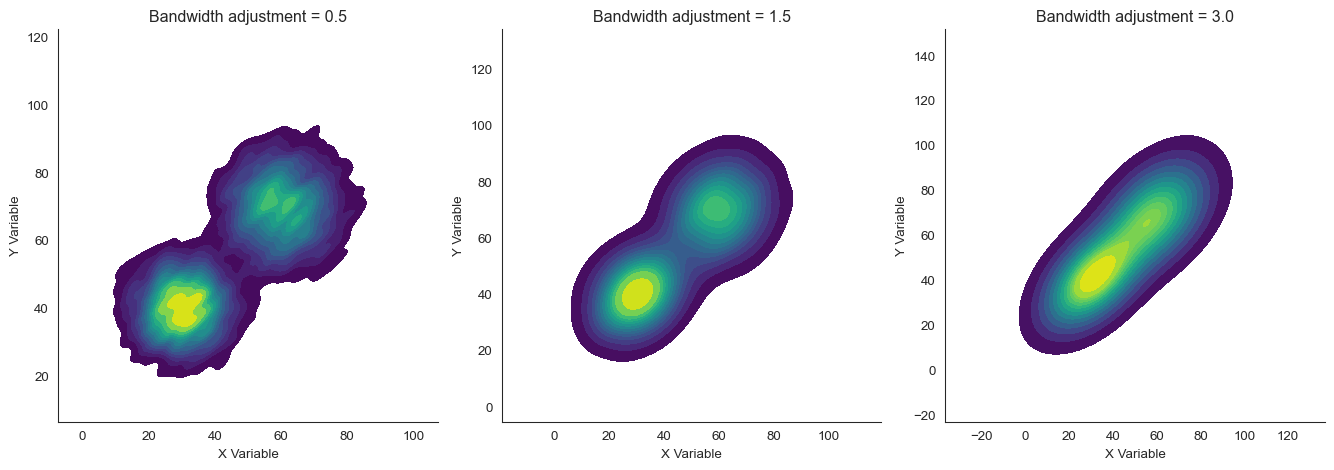

In [9]:
#| fig-cap: Effect of bandwidth on 2D KDE smoothness
#| code-fold: true
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
bandwidths = [0.5, 1.5, 3.0]

for ax, bw in zip(axes, bandwidths):
    sns.kdeplot(x=x_clusters, y=y_clusters, cmap='viridis', fill=True,
                bw_adjust=bw, thresh=0.05, levels=15, ax=ax)
    ax.set_xlabel('X Variable')
    ax.set_ylabel('Y Variable')
    ax.set_title(f'Bandwidth adjustment = {bw}')
    sns.despine(ax=ax)

plt.tight_layout()

With `bw_adjust=0.5` (narrow bandwidth), we see fine detail but some noise. With `bw_adjust=3.0` (wide bandwidth), the plot is very smooth but the two clusters nearly merge. The default `bw_adjust=1.0` (or around 1.5 here) balances detail and smoothness.

## Contour Plots

A **contour plot** represents the density surface as lines of equal densitylike a topographic map where each contour line represents an "elevation" of density.

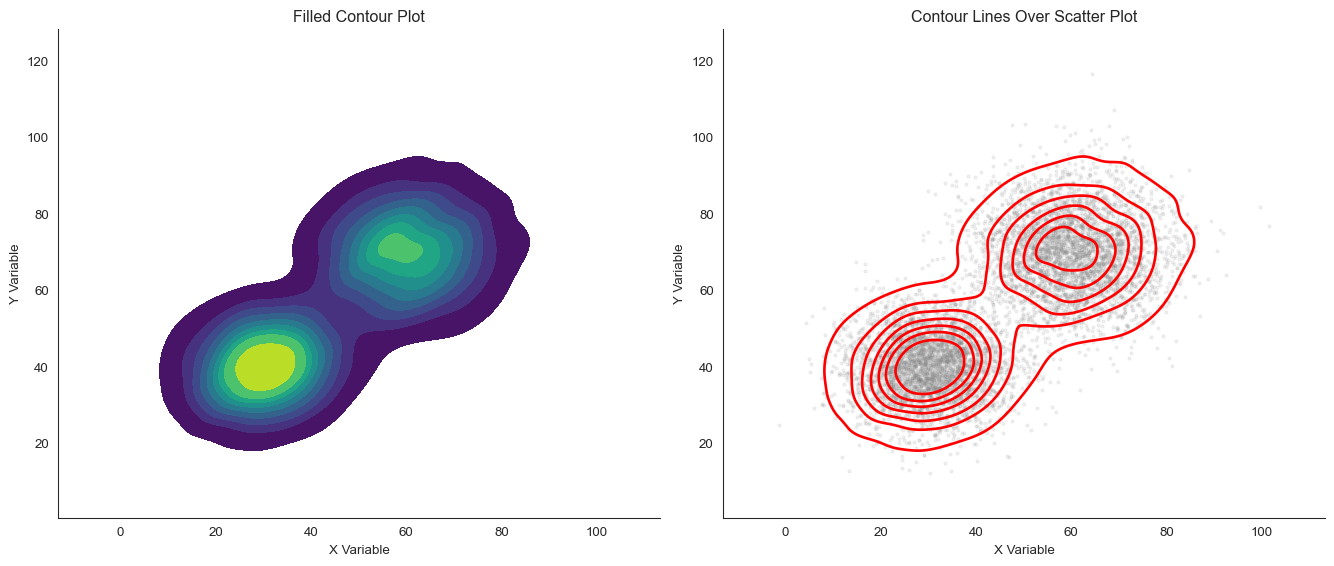

In [10]:
#| fig-cap: Contour plot shows density as topographic lines
#| code-fold: true
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Filled contours
sns.kdeplot(x=x_clusters, y=y_clusters, cmap='viridis', fill=True,
            thresh=0.05, levels=10, ax=axes[0])
axes[0].set_xlabel('X Variable')
axes[0].set_ylabel('Y Variable')
axes[0].set_title('Filled Contour Plot')
sns.despine(ax=axes[0])

# Line contours with scatter
axes[1].scatter(x_clusters, y_clusters, alpha=0.1, s=5, c='gray')
sns.kdeplot(x=x_clusters, y=y_clusters, levels=8, color='red', linewidths=2, ax=axes[1])
axes[1].set_xlabel('X Variable')
axes[1].set_ylabel('Y Variable')
axes[1].set_title('Contour Lines Over Scatter Plot')
sns.despine(ax=axes[1])

plt.tight_layout()

Contour plots are excellent for:
- Overlaying density information on scatter plots
- Comparing multiple groups (different colored contours)
- Showing the "shape" of the relationship clearly

# Joint Distributions: Combining 2D and 1D

A powerful approach is to show both the **joint (2D) distribution** and the **marginal (1D) distributions** of each variable. This connects 2D visualization back to the 1D methods we learned earlier.

A **joint plot** combines a central 2D plot with 1D histograms or density plots along the margins.

Text(0.5, 1.01, 'Joint Distribution with Marginal Histograms')

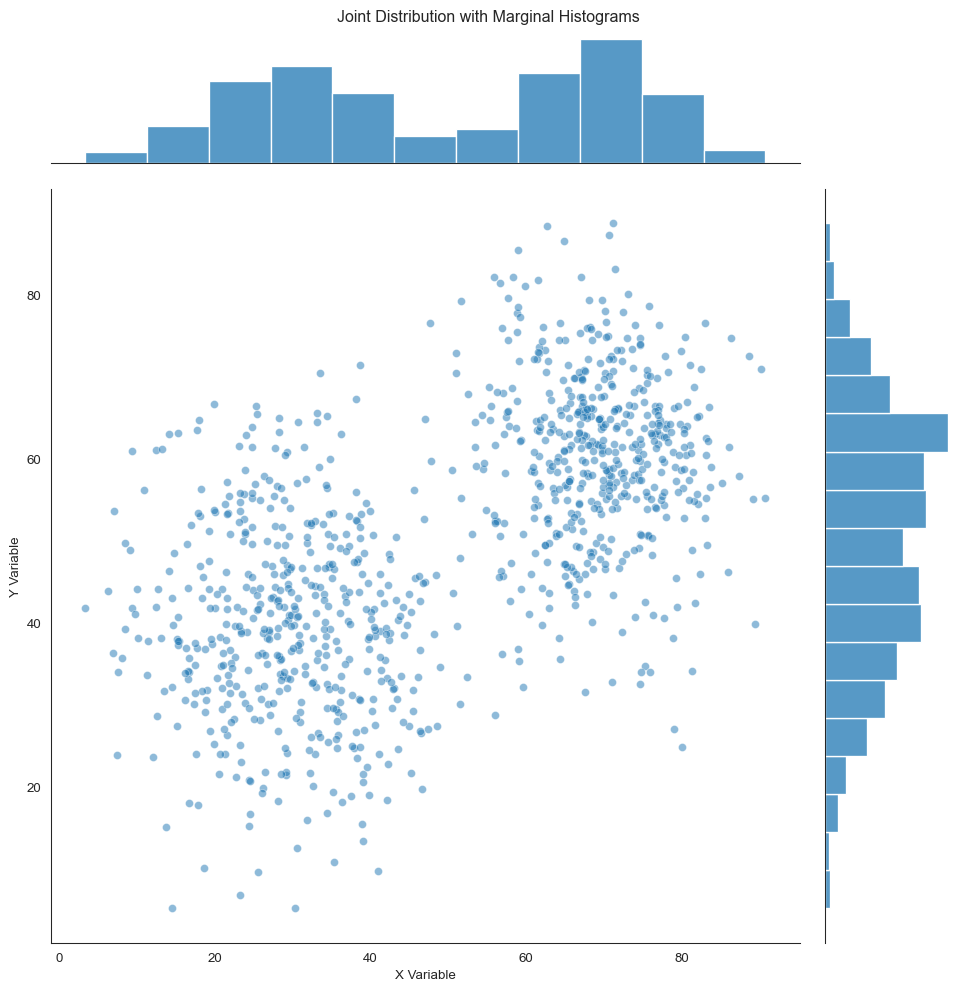

In [11]:
#| fig-cap: Joint plot combining 2D scatter with marginal 1D distributions
#| code-fold: true
# Generate data with interesting marginals
np.random.seed(202)
n = 1000
x_joint = np.concatenate([np.random.normal(30, 10, n//2), np.random.normal(70, 8, n//2)])
y_joint = np.concatenate([np.random.normal(40, 12, n//2), np.random.normal(60, 10, n//2)])

# Create joint plot
g = sns.jointplot(x=x_joint, y=y_joint, kind='scatter', alpha=0.5, height=10)
g.set_axis_labels('X Variable', 'Y Variable')
g.fig.suptitle('Joint Distribution with Marginal Histograms', y=1.01)

The marginal distributions (top and right) show that both X and Y are bimodalthere are two peaks. But the scatter plot reveals that the peaks are *correlated*: when X is low, Y tends to be low; when X is high, Y tends to be high. This relationship is invisible in the marginals alone.

Joint plots can use different visualizations in the center:

Text(0.5, 1.01, 'Joint Plot: Hexbin Center with KDE Margins')

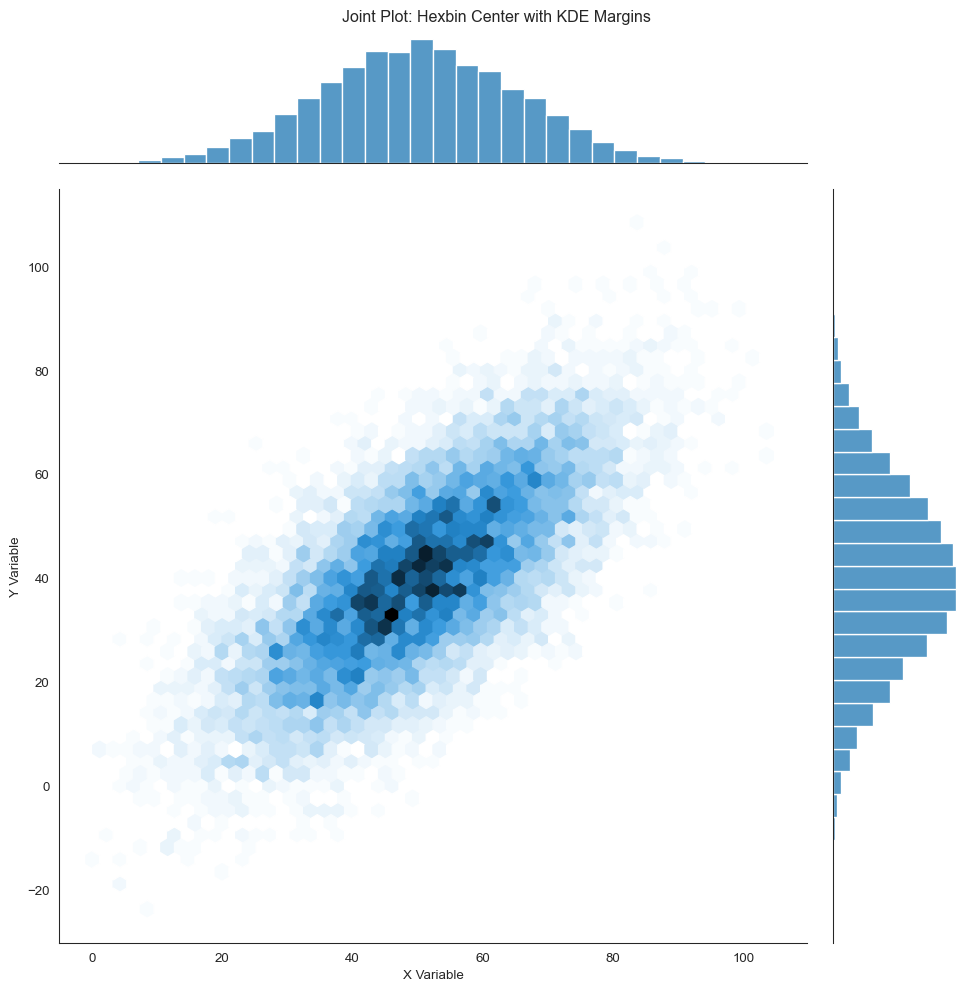

In [12]:
#| fig-cap: Joint plot with hexbin center and KDE margins
#| code-fold: true
# Create joint plot with hexbin and KDE
g = sns.jointplot(x=x_large, y=y_large, kind='hex', height=10,
                  marginal_kws=dict(bins=30, fill=True))
g.set_axis_labels('X Variable', 'Y Variable')
g.fig.suptitle('Joint Plot: Hexbin Center with KDE Margins', y=1.01)

Or with KDE everywhere:

Text(0.5, 1.01, 'Joint Plot: All KDE')

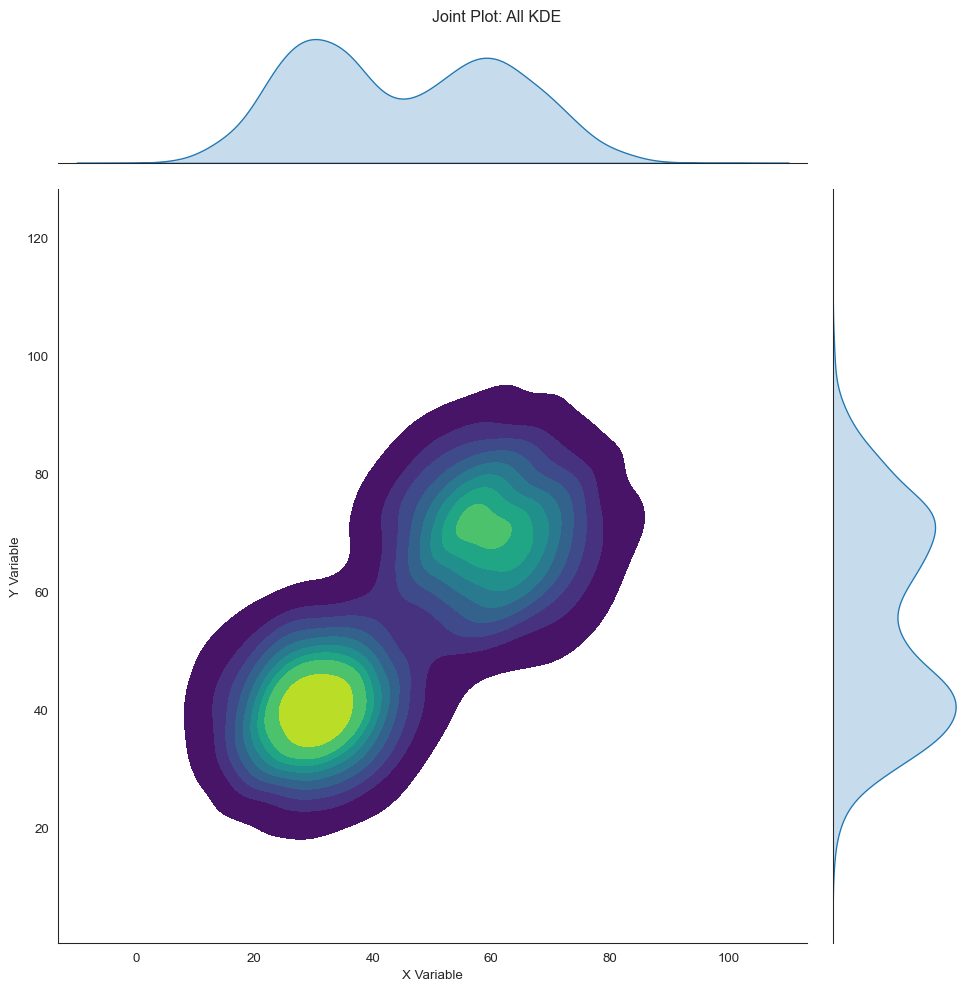

In [13]:
#| fig-cap: Joint plot with 2D KDE center and 1D KDE margins
#| code-fold: true
g = sns.jointplot(x=x_clusters, y=y_clusters, kind='kde', height=10,
                  fill=True, cmap='viridis', thresh=0.05)
g.set_axis_labels('X Variable', 'Y Variable')
g.fig.suptitle('Joint Plot: All KDE', y=1.01)

Joint plots are particularly useful for:
- Understanding if marginal distributions are misleading about the relationship
- Seeing if there's correlation between variables with interesting univariate structure
- Presenting a complete picture of a bivariate relationship

::: {.column-margin}

**Pro tip**: When presenting data, start with marginal distributions to establish what each variable looks like, then show the joint distribution to reveal the relationship. This guides your audience from the familiar (1D) to the complex (2D).

:::

# Visualizing Relationships Across Groups

Often we want to compare relationships across multiple groups or categories. There are several effective approaches.

## Color coding by group

The simplest approach is to use different colors for different groups:

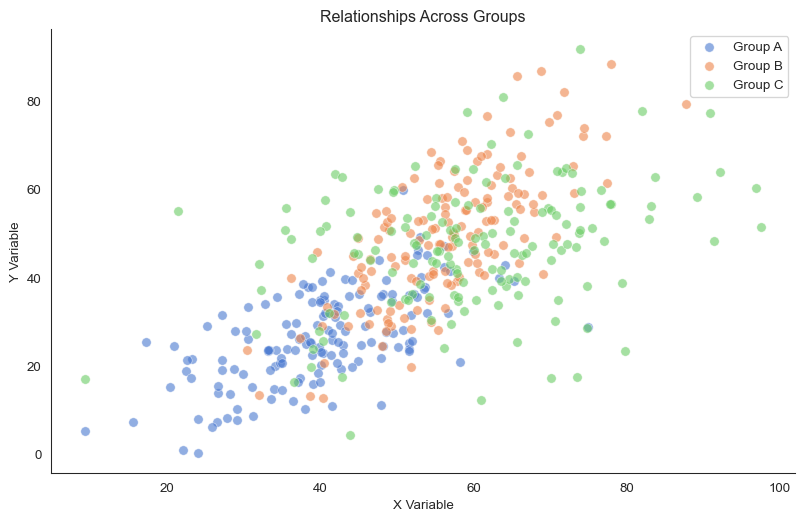

In [14]:
#| fig-cap: Scatter plot with color-coded groups
#| code-fold: true
# Generate multi-group data
np.random.seed(303)
n_per_group = 150

group_a_x = np.random.normal(40, 12, n_per_group)
group_a_y = 0.7 * group_a_x + np.random.normal(0, 8, n_per_group)

group_b_x = np.random.normal(55, 10, n_per_group)
group_b_y = 1.2 * group_b_x + np.random.normal(-20, 10, n_per_group)

group_c_x = np.random.normal(60, 15, n_per_group)
group_c_y = 0.3 * group_c_x + np.random.normal(30, 12, n_per_group)

df_groups = pd.DataFrame({
    'x': np.concatenate([group_a_x, group_b_x, group_c_x]),
    'y': np.concatenate([group_a_y, group_b_y, group_c_y]),
    'group': ['A'] * n_per_group + ['B'] * n_per_group + ['C'] * n_per_group
})

fig, ax = plt.subplots(figsize=(10, 6))
for group, color in zip(['A', 'B', 'C'], sns.color_palette('muted', 3)):
    subset = df_groups[df_groups['group'] == group]
    ax.scatter(subset['x'], subset['y'], label=f'Group {group}',
               alpha=0.6, s=50, color=color, edgecolors='white', linewidth=0.5)

ax.set_xlabel('X Variable')
ax.set_ylabel('Y Variable')
ax.set_title('Relationships Across Groups')
ax.legend()
sns.despine()

This reveals that the three groups have different relationships: Group A has a positive moderate slope, Group B has a steeper positive relationship, and Group C has almost no relationship.

::: {.callout-warning}
## Simpson's Paradox

Be careful! Sometimes the overall trend (pooling all groups) can be opposite to the trend within each group. This is called **Simpson's Paradox**. Always visualize groups separately to check if pooling is appropriate.
:::

## Small multiples (faceting)

When groups overlap heavily or there are many groups, **small multiples**separate plots for each groupwork better than color coding:

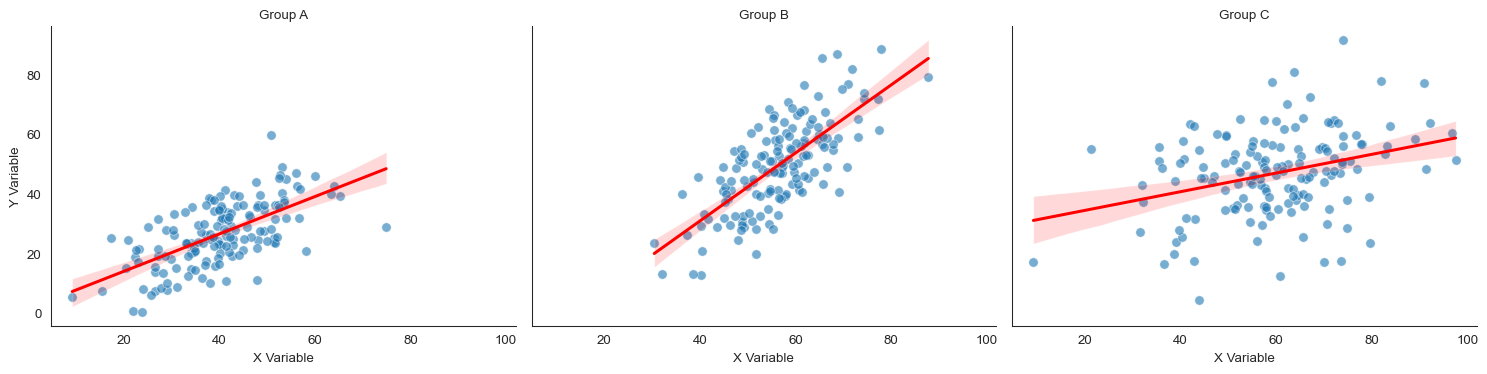

In [15]:
#| fig-cap: Small multiples showing relationship for each group separately
#| code-fold: true
g = sns.FacetGrid(df_groups, col='group', height=4, aspect=1.3)
g.map_dataframe(sns.scatterplot, x='x', y='y', alpha=0.6, s=50)
g.map_dataframe(sns.regplot, x='x', y='y', scatter=False, color='red')
g.set_axis_labels('X Variable', 'Y Variable')
g.set_titles('Group {col_name}')
sns.despine()
plt.tight_layout()

Small multiples make it easy to compare the strength and direction of relationships across groups without visual clutter.

## Contour overlays

For large datasets, overlaying density contours for each group can be very effective:

/var/folders/j7/9dgqq5g53vnbsbmvh2yqtckr0000gr/T/ipykernel_89556/3335885635.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


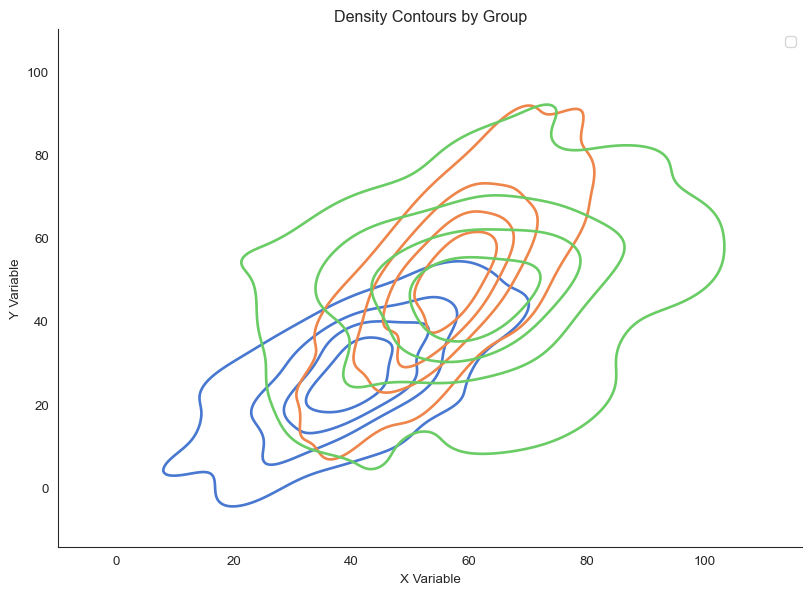

In [16]:
#| fig-cap: Overlaid density contours reveal different relationship shapes
#| code-fold: true
fig, ax = plt.subplots(figsize=(10, 7))

colors = sns.color_palette('muted', 3)
for group, color in zip(['A', 'B', 'C'], colors):
    subset = df_groups[df_groups['group'] == group]
    sns.kdeplot(x=subset['x'], y=subset['y'], levels=5,
                color=color, linewidths=2, label=f'Group {group}', ax=ax)

ax.set_xlabel('X Variable')
ax.set_ylabel('Y Variable')
ax.set_title('Density Contours by Group')
ax.legend()
sns.despine()

This clearly shows that Groups A and B have elongated, correlated distributions (indicating strong relationships), while Group C is more circular (indicating weak correlation).

# The Bigger Picture

Visualizing bivariate relationships isn't just about making pretty picturesit's about **seeing patterns that summary statistics conceal**.

When you reduce a relationship to a single number (a correlation coefficient, a slope, a p-value), you lose crucial information:
- Is the relationship linear or curved?
- Are there outliers driving the result?
- Are there subgroups with different patterns?
- Is the relationship consistent across the range of your data?

Anscombe's Quartet taught us this lesson half a century ago, yet papers still report correlations without showing scatter plots. Don't make this mistake.

The choice of visualization method matters:
- **Scatter plots** for small to moderate datasets where individual points matter
- **Hexbin or heatmaps** for large datasets where density matters more than individuals
- **2D KDE and contours** for smooth, assumption-light density estimation
- **Joint plots** for connecting bivariate relationships to univariate distributions

But the most important choice is the simplest: **always plot your data**. Let your audience see what you see. Trust them to interpret patterns, not just summary statistics.

As statistician John Tukey wrote: "The greatest value of a picture is when it forces us to notice what we never expected to see."